# A/B  тестирование. Метод линеаризованных лайков.


__Вводные данные:__

Параллельно проводятся два теста.

Дата проведения тестов: с 2023-01-31 по 2023-02-06

Первый тест:
* exp_group = 1 - Все по-старому
* exp_group = 2 - Рекомендации "похожих на лайкнутые постов"

Второй тест:
* exp_group = 0 – Все по-старому
* exp_group = 3 - Рекомендации "постов, которые лайкали похожие на вас люди"



__Задача: проанализировать данные АB-теста в группах 0-3 и 1-2 методом линеаризованных лайков.__ 


__Формируем гипотезы:__

Н0 = Различий между группами нет.

Н1 = Различия между группами есть.

### Вывод из анализа AB теста 0 и 3 групп
Глобальный CTR 2-й группы (экспериментальной) оказался ниже, чем в контрольной. Из чего следует, что новый алгоритм во 2-й группе привёл к ухудшени. Соответственно раскатывать новый алгоритм на всех новых пользователей не стоит. Может быть стоит проверить корректность проведения AB теста, т.к распределение CTR второй группы выглядит не характерно

### Вывод из анализа AB теста 1 и 2 групп
Первый тест по метрике linearize_likes более чувствителен и показывает, что отличия между группами есть. t-test по метрике ctr , говорит, что группы одинаковые. Мне кажется, что при таком распределении данных во второй группе вообще не коректно использовать просто t-test.

In [1]:
import pandas as pd
import pandahouse as ph
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats

In [2]:
#сразу установим параметры вывода графиков 
sns.set(
    rc={
        "figure.figsize": (12, 8), #размер графика - 12 дюймов в ширину, 8 в длину
        "axes.titlesize": 20, #размер заголовка 
        "axes.labelsize": 14, #размер подписей осей
        "xtick.labelsize": 13, #размер подписей чёрточек на x-оси
        "ytick.labelsize": 13, #размер подписей чёрточек на y-оси
    }
)

## AB тест для групп 1 и 2


In [3]:
connection = {'host': ,
                      'database':,
                      'user':, 
                      'password':
                     }

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-01-31' and '2023-02-06'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)

df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


Посмотрим общее описание по каждой группе

In [4]:
df[df.exp_group == 1].describe()

,exp_group,user_id,likes,views,ctr
count,10079.0,10079.000000,10079.000000,10079.000000,10079.000000
mean,1.0,75540.955948,13.792142,66.299831,0.215605
std,0.0,53211.834816,9.798990,45.043411,0.084160
min,1.0,206.000000,0.000000,2.000000,0.000000
25%,1.0,22227.000000,7.000000,32.000000,0.160097
50%,1.0,109360.000000,12.000000,56.000000,0.203125
75%,1.0,126200.500000,19.000000,90.000000,0.257654
max,1.0,140500.000000,81.000000,311.000000,0.722222


In [5]:
df[df.exp_group == 2].describe()

,exp_group,user_id,likes,views,ctr
count,9952.0,9952.000000,9952.000000,9952.000000,9952.000000
mean,2.0,75142.800543,13.101387,66.148513,0.214419
std,0.0,53315.378033,11.838030,45.151210,0.144180
min,2.0,220.000000,0.000000,1.000000,0.000000
25%,2.0,21904.250000,5.000000,32.000000,0.095238
50%,2.0,109112.500000,9.000000,56.000000,0.142857
75%,2.0,126228.250000,17.000000,91.000000,0.325000
max,2.0,141164.000000,95.000000,321.000000,0.923077


In [6]:
print('Количество пользователей в группах отличаются на',\
      f'{round((abs(1-df[df.exp_group == 1].user_id.nunique()/df[df.exp_group == 2].user_id.nunique()))*100, 2)} %')

Количество пользователей в группах отличаются на 1.28 %


In [7]:
print('Средние значения CTR группах отличаются на',\
      f'{round(abs(df[df.exp_group == 1].ctr.mean()-df[df.exp_group == 2].ctr.mean()), 4)} ')

Средние значения CTR группах отличаются на 0.0012 


В группе 2 меньше, чем в группе 1

In [8]:
print('Медианные значения CTR группах отличаются на',\
      f'{round(abs(df[df.exp_group == 1].ctr.median()-df[df.exp_group == 2].ctr.median()), 4)} ')

Медианные значения CTR группах отличаются на 0.0603 


В группе 2 меньше, чем в группе 1

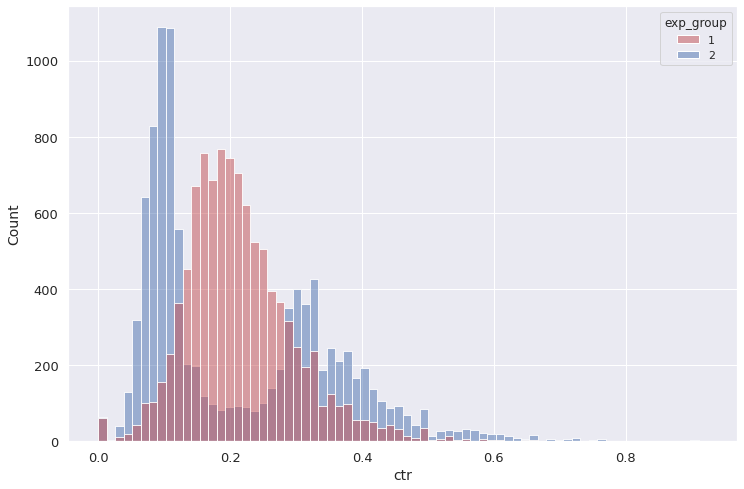

In [9]:
#посмотрим визуально распределение ctr в наших группах
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Визуально распределения CTR разные. Если контрольная группа как-то напоминает нормальное распределение, то экспериментальная точно нет: "двугорбое" распределение и как будто пользователи поделились на 2 группы: одна с малыми значениями CTR, а для второй характерны более высокие CTR. 

In [10]:
#Считаем общий CTR в контрольной группе:  𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠)
ctr_control = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
ctr_control

0.20802680490126244

In [11]:
#Посчитаем в обеих группах поюзерную метрику:  𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠
df['linearize_likes'] = df.likes - ctr_control*df.views
df.head()

,exp_group,user_id,likes,views,ctr,linearize_likes
0,1,109963,3,15,0.200000,-0.120402
1,1,26117,32,141,0.226950,2.668221
2,1,138232,18,73,0.246575,2.814043
3,1,26295,33,122,0.270492,7.620730
4,1,18392,7,32,0.218750,0.343142


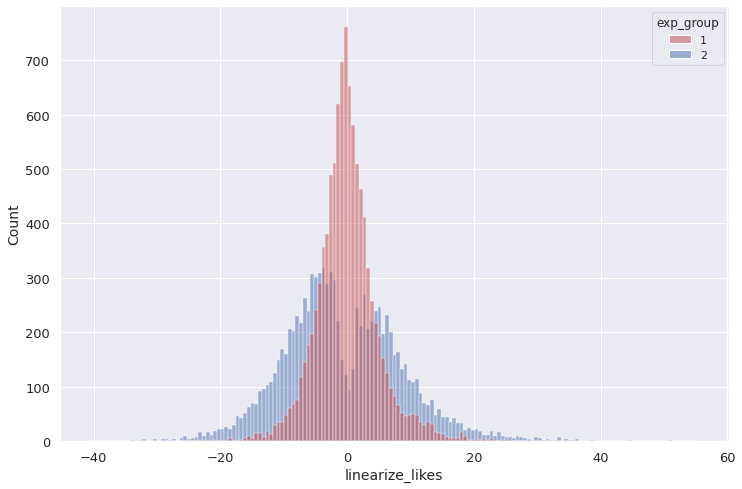

In [12]:
#посмотрим визуально распределение linearize_likes в наших группах
groups = sns.histplot(data = df, 
              x='linearize_likes', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Распределения очень разные. Даже если не брать во внимание "двугорбость" второй группы. распределение второй группы больше сосредоточено в отрицательных значениях.

In [13]:
#сравним  t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠
stats.ttest_ind(df[df.exp_group == 1].linearize_likes,
                df[df.exp_group == 2].linearize_likes,
                equal_var=False)

Ttest_indResult(statistic=6.122579994775972, pvalue=9.439432187037712e-10)

In [14]:
#теперь сравним  t-тестом отличия в группах по метрике ctr
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

pvalue > 0.05. t-test по метрике ctr подтверждает гипотезу о равенстве ctr групп 1 и 2


### Вывод из анализа AB теста 1 и 2 групп


Первый тест по метрике linearize_likes более чувствителен и показывает, что отличия между группами есть. t-test по метрике ctr , говорит, что группы одинаковые. Мне кажется, что при таком распределении данных во второй группе вообще не коректно использовать просто t-test.

## AB тест для групп 0 и 3


In [15]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-01-31' and '2023-02-06'
    and exp_group in (0,3)
GROUP BY exp_group, user_id
"""

df1 = ph.read_clickhouse(q, connection=connection)

df1.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,9,30,0.300000
1,3,123580,13,48,0.270833
2,0,4944,8,41,0.195122
3,0,4504,5,15,0.333333
4,0,121508,18,88,0.204545


Посмотрим общее описание по каждой группе

In [16]:
df1[df1.exp_group == 0].describe()


,exp_group,user_id,likes,views,ctr
count,9999.0,9999.000000,9999.000000,9999.000000,9999.000000
mean,0.0,76733.355236,13.987599,67.171817,0.215950
std,0.0,53121.995152,9.992538,45.541362,0.083628
min,0.0,201.000000,0.000000,1.000000,0.000000
25%,0.0,22537.000000,7.000000,32.000000,0.162162
50%,0.0,109916.000000,12.000000,57.000000,0.202899
75%,0.0,126891.000000,19.000000,91.000000,0.257143
max,0.0,140487.000000,88.000000,363.000000,0.777778


In [17]:
df1[df1.exp_group == 3].describe()



,exp_group,user_id,likes,views,ctr
count,10049.0,10049.000000,10049.000000,10049.000000,10049.000000
mean,3.0,75044.407304,14.962583,66.709125,0.232624
std,0.0,53299.776433,10.581350,45.811361,0.086247
min,3.0,200.000000,0.000000,1.000000,0.000000
25%,3.0,22166.000000,7.000000,32.000000,0.176471
50%,3.0,109057.000000,13.000000,56.000000,0.220339
75%,3.0,126252.000000,20.000000,91.000000,0.276786
max,3.0,140489.000000,107.000000,373.000000,0.818182


In [18]:
print('Количество пользователей в группах отличаются на',\
      f'{round((1-df1[df1.exp_group == 0].user_id.nunique()/df1[df1.exp_group == 3].user_id.nunique())*100, 2)} %')

Количество пользователей в группах отличаются на 0.5 %


In [19]:
print('Средние значения CTR группах отличаются на',\
      f'{round(abs(df1[df1.exp_group == 0].ctr.mean()-df1[df1.exp_group == 3].ctr.mean()), 4)} ')

Средние значения CTR группах отличаются на 0.0167 


In [20]:
print('Медианные значения CTR группах отличаются на',\
      f'{round(abs(df1[df1.exp_group == 0].ctr.median()-df1[df1.exp_group == 3].ctr.median()), 4)} ')

Медианные значения CTR группах отличаются на 0.0174 


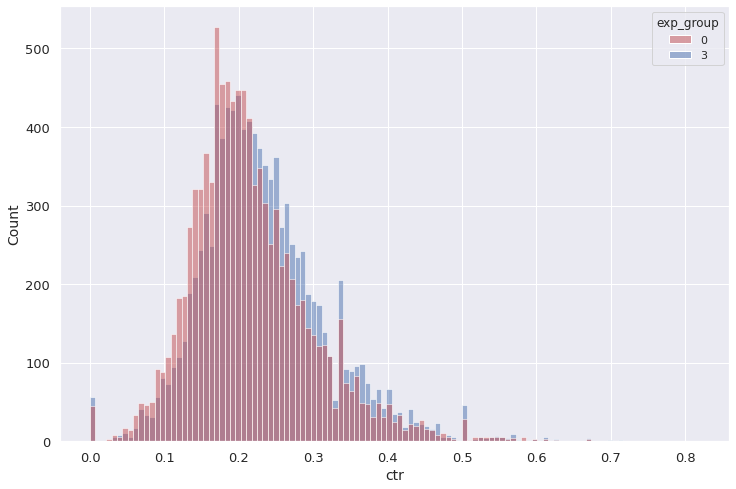

In [21]:
#посмотрим визуально распределение ctr в наших группах
groups = sns.histplot(data = df1, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Визуально распределения CTR разные. Распределение группы 3 чуть правее распределения группы 0.

In [22]:
#Считаем общий CTR в контрольной группе:  𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠)
ctr_control = df1[df1.exp_group == 0].likes.sum()/df1[df1.exp_group == 0].views.sum()
ctr_control

0.20823612262916305

In [23]:
#Посчитаем в обеих группах поюзерную метрику:  𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠
df1['linearize_likes'] = df1.likes - ctr_control*df1.views
df1.head()

,exp_group,user_id,likes,views,ctr,linearize_likes
0,3,115383,9,30,0.300000,2.752916
1,3,123580,13,48,0.270833,3.004666
2,0,4944,8,41,0.195122,-0.537681
3,0,4504,5,15,0.333333,1.876458
4,0,121508,18,88,0.204545,-0.324779


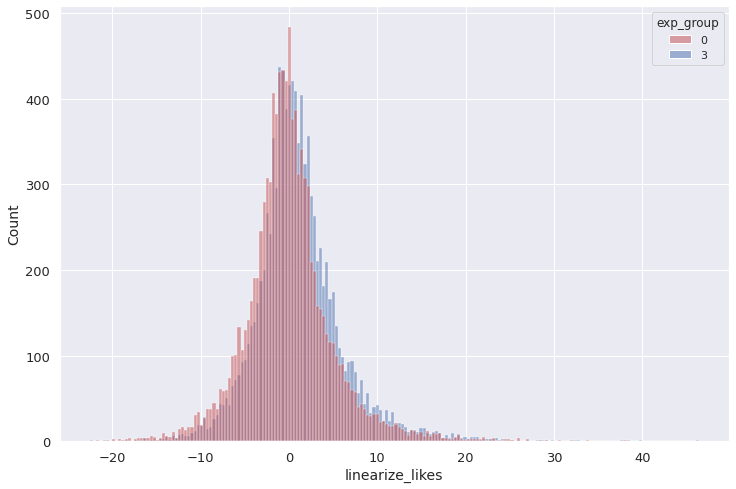

In [24]:
#посмотрим визуально распределение linearize_likes в наших группах
groups = sns.histplot(data = df1, 
              x='linearize_likes', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [25]:
#сравним  t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠
stats.ttest_ind(df1[df1.exp_group == 0].linearize_likes,
                df1[df1.exp_group == 3].linearize_likes,
                equal_var=False)

Ttest_indResult(statistic=-15.21499546090383, pvalue=5.4914249479687664e-52)

pvalue < 0.05 -  различия в группах есть

In [26]:
#теперь сравним  t-тестом отличия в группах по метрике ctr
stats.ttest_ind(df1[df1.exp_group == 0].ctr,
                df1[df1.exp_group == 3].ctr,
                equal_var=False)

Ttest_indResult(statistic=-13.896870721904069, pvalue=1.055849414662529e-43)

pvalue также < 0.05 , но значение само значение pvalue гораздо больше в этот раз. Первый тест по метрике linearize_likes показывает большую чувствительность

### Вывод из анализа AB теста 0 и 3 групп
Глобальный CTR 2-й группы (экспериментальной) оказался ниже, чем в контрольной. Из чего следует, что новый алгоритм во 2-й группе привёл к ухудшени. Соответственно раскатывать новый алгоритм на всех новых пользователей не стоит. Может быть стоит проверить корректность проведения AB теста, т.к распределение CTR второй группы выглядит не характерно